# Intial Data Investigation

Here we'll investigate both train and test datasets for gaining more insight into the data in order to come up with right ideas for modelling phase.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# import our modules here
from modules.DataHandler import *
from modules.utils import *

# HandleData: used for downloading dataset (txt) files and handle the data we get
datahandler = DataHandler()

## 1. Balance of target clases

Unbalanced data will sure affect the predictive model and lead to a biased result. Thus, we'll check if class distribution in each dataset is balanced. If not, then we'll carry out necessary steps, such as oversampling or undersampling in pre-processing steps.

In [2]:
prefix = ['train', 'test']

for p in prefix:
    print('\n{}-SET\nclass\tnumber\t%-wise'.format(p.upper()))
    
    # load file
    data=datahandler.load_txt('UCI HAR Dataset/{}/y_{}.txt'.format(p, p))
    # count the number of occurance for each classes
    class_count = pd.value_counts(data.iloc[:,0])
    
    for c in range(len(class_count)):
        print('%d\t%d\t%.2f' %(class_count.index[c], 
                               class_count.values[c], 
                               100*class_count.values[c]/sum(class_count)))


TRAIN-SET
class	number	%-wise
6	1407	19.14
5	1374	18.69
4	1286	17.49
1	1226	16.68
2	1073	14.59
3	986	13.41

TEST-SET
class	number	%-wise
6	537	18.22
5	532	18.05
1	496	16.83
4	491	16.66
2	471	15.98
3	420	14.25


*It looks like distribution of our clsses is fairly normal. So it's safe to continue.*

## 2. Plot data

Pre-processed raw data had fixed windows of 2.56 seconds (128 data points) with a 50% overlap. For avoiding duplications due to overlapping in plotting, we'll remove overlaps and squash data frames it to the series. 

#### Load data

In [3]:
# get train and test raw data

prefix = 'train'
X_train = datahandler.load_files('UCI HAR Dataset/{p}/Inertial Signals/'.format(p=prefix))
y_train = datahandler.load_txt('UCI HAR Dataset/{p}/y_{p}.txt'.format(p=prefix)).values

# get index that map rows to each subject in the dataset
sub_indices_train = datahandler.load_txt('UCI HAR Dataset/{p}/subject_{p}.txt'.format(p=prefix))


prefix = 'test'
X_test = datahandler.load_files('UCI HAR Dataset/{p}/Inertial Signals/'.format(p=prefix))
y_test = datahandler.load_txt('UCI HAR Dataset/{p}/y_{p}.txt'.format(p=prefix)).values

# get index that map rows to each subject in the dataset
sub_indices_test = datahandler.load_txt('UCI HAR Dataset/{p}/subject_{p}.txt'.format(p=prefix))

In [4]:
# print data info

print('TRAIN\nX={}'.format(X_train.shape))
print('y={}'.format(y_train.shape))
print('activities={}'.format(np.unique(y_train)))
print('subjects={}\n'.format(np.unique(sub_indices_train)))

print('TEST\nX={}'.format(X_test.shape))
print('y={}'.format(y_test.shape))
print('activities={}'.format(np.unique(y_test)))
print('subjects={}'.format(np.unique(sub_indices_test)))

TRAIN
X=(7352, 128, 9)
y=(7352, 1)
activities=[1 2 3 4 5 6]
subjects=[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]

TEST
X=(2947, 128, 9)
y=(2947, 1)
activities=[1 2 3 4 5 6]
subjects=[ 2  4  9 10 12 13 18 20 24]


### 2.1 Plot time series for a subject

for train we used subject 1, for test we used subject 2.

In [5]:
# retrive all observations (rows) for a signe subject (for a given subject_id)

sub_X_train = datahandler.get_subject_data(X_train, sub_indices_train, subject_id=1)
sub_y_train = datahandler.get_subject_data(y_train, sub_indices_train, subject_id=1)

sub_X_test = datahandler.get_subject_data(X_test, sub_indices_test, subject_id=2)
sub_y_test = datahandler.get_subject_data(y_test, sub_indices_test, subject_id=2)

# remove overlap
sub_X_train = datahandler.remove_overlap(sub_X_train)
sub_X_test  =  datahandler.remove_overlap(sub_X_test)

# print data info
print('sub_X_train={}'.format(sub_X_train.shape))
print('sub_X_test={}'.format(sub_X_test.shape))

sub_X_train=(21861, 9)
sub_X_test=(19026, 9)


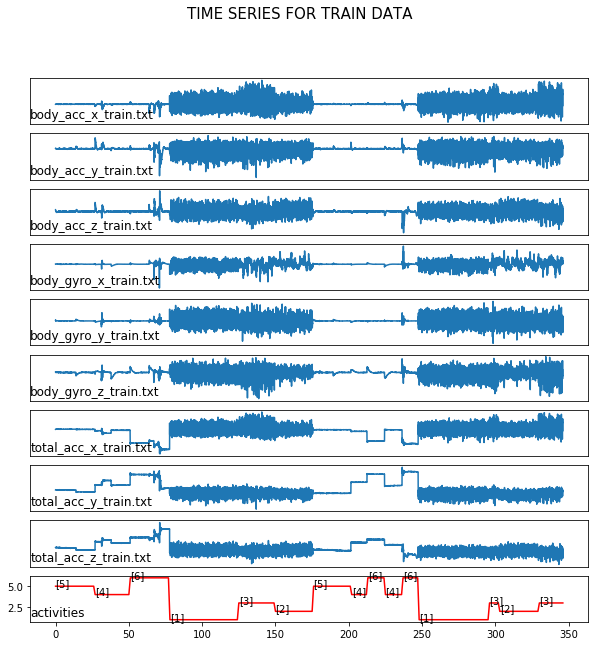

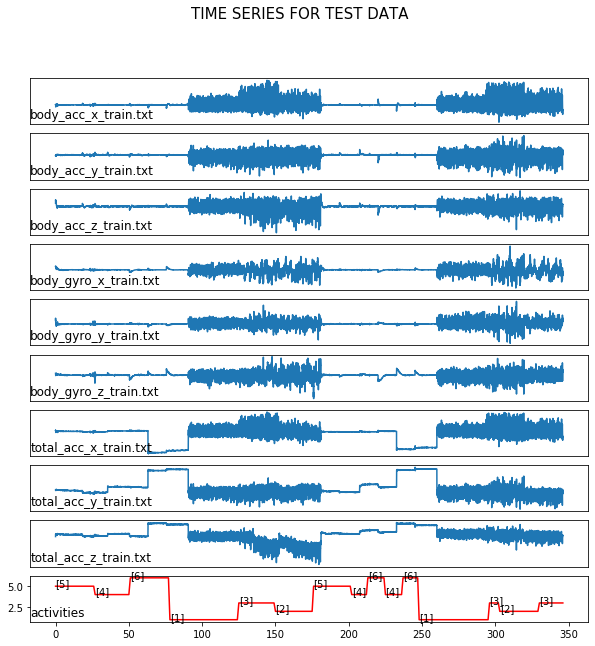

In [138]:
def plot_time_series(sub_data, signal_names, title):
    
    # create subplot
    fig, ax = plt.subplots(nrows=len(signal_names)+1, ncols=1, figsize=(10,10), squeeze=True)

    # iterate over each signal
    for i in range(len(signal_names)):
        # add time series of corresponding inertial signal values
        ax[i].plot(sub_data[:, i])
        ax[i].set_title(signal_names[i], y=0, loc='left')
        # make axes unvisible
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)

    # add activity values to last ax
    ax[-1].plot(sub_y_train, 'r')
    ax[-1].set_title('activities', y=0, loc='left')
    
    # annotate activity number when there is a change
    temp_j = 0
    for i,j in enumerate(sub_y_train):
        if temp_j!=j:
            temp_j=j
            ax[-1].annotate(str(j),xy=(i,j))
            
    fig.suptitle(title.upper(), fontsize=15)
    plt.show()
    
    
plot_time_series(sub_X_train, signal_names, 'time series for train data')
plot_time_series(sub_X_test,  signal_names, 'time series for test data')

As it's clear from the fluctuations in the post, periods of too much movement corresponding to walking activities (1:walking
2: walking upstairs, 3: walking Downstairs). On the contrary, the less activity periods account for stationary activities (4: sitting, 5: standing, 6: laying). This gives the idea that the raw feature will be helpful for cleasifying at at least between walking activities and stationary ativities.